In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML

In [7]:
import numpy as np
import pandas as pd

import os
import pathlib

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

**Data Importing**

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!unzip /content/gdrive/MyDrive/Data-Tomato.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/Tomato_Late_blight/afb65a40-7512-4d2c-884e-56e6c5010511___RS_Late.B 5380.JPG  
  inflating: Data/Tomato_Late_blight/aff90d5c-a3f2-445a-b125-717a00b21fb8___RS_Late.B 6624.JPG  
  inflating: Data/Tomato_Late_blight/b07f5c6e-2e85-4b45-a166-522cc484619c___RS_Late.B 6276.JPG  
  inflating: Data/Tomato_Late_blight/b09b2807-58ca-4708-904e-05de3032ef92___RS_Late.B 6345.JPG  
  inflating: Data/Tomato_Late_blight/b0a1ada0-f496-46a3-827e-2d721dabee59___GHLB2 Leaf 9086.JPG  
  inflating: Data/Tomato_Late_blight/b0e6fd13-ea0c-4e04-bdd3-70878b71f353___GHLB2 Leaf 106.1.JPG  
  inflating: Data/Tomato_Late_blight/b0fbd7bd-f906-489b-96ff-a2683eb76dd3___RS_Late.B 6173.JPG  
  inflating: Data/Tomato_Late_blight/b15c92e9-6973-415c-80fe-82703ff722f7___RS_Late.B 4994.JPG  
  inflating: Data/Tomato_Late_blight/b17fad17-1d16-4a55-9b4e-d1a35ddbb611___GHLB2 Leaf 8933.JPG  
  inflating: Data/Tomato_Late_blight/b19055d9-6a5d-4b73-90a5-3b3685ac344

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [10]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 7 7 2 7 2 3 9 7 5 3 2 7 0 0 5 9 4 5 6 4 7 0 7 3 9 2 9 3 2 0 6]


*Visualize some of the images from our dataset*

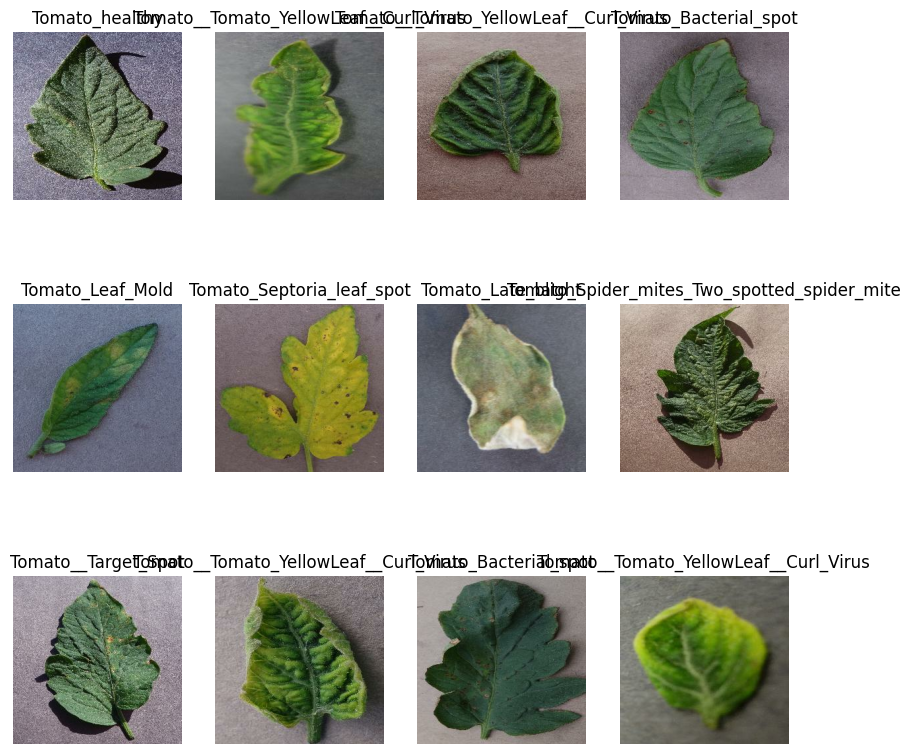

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

**Dataset Partition**
Train = 80%
test = 10%
validate = 10%

In [13]:
len(dataset)

501

In [14]:
train_size = 0.8
len(dataset)*train_size

400.8

In [15]:
train_ds = dataset.take(160)
len(train_ds)
# took 160 batches as training set

160

In [16]:
test_ds = dataset.skip(160)
len(test_ds)

341

In [17]:
val_ds = test_ds.take(20)
len(val_ds)
# took 20 batches as training set

20

In [18]:
test_ds = test_ds.skip(20).take(20)
len(test_ds)
# took 20 batches as training set

20

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
print("Train = ",len(train_ds))
print("Validation = ",len(val_ds))
print("test = ",len(test_ds))

Train =  160
Validation =  20
test =  20


# Building the Model

In [20]:

# Data Rescale and resize

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
from tensorflow.keras.applications import EfficientNetB0
num=len(class_names)

In [35]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    #x = img_augmentation(inputs)
    x = inputs
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    model.trainable=  True

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [28]:
# def build_model(num_classes):
#     inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

#     # Freeze the pre-trained layers
#     model = tf.keras.applications.EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")
#     model.trainable = True

#     # Use a max pooling layer to extract feature vectors
#     x = tf.keras.layers.MaxPooling2D(name="max_pool")(model.output)

#     # Add a dropout layer
#     top_dropout_rate = 0.2
#     x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)

#     # Add the output layer
#     outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

#     # Compile the model
#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
#     model = tf.keras.Model(inputs, outputs, name="EfficientNetB7")
#     model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#     return model


In [36]:

model_efficeientNet = build_model(num)
model_efficeientNet.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 256, 256, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 256, 256, 3)          7         ['rescaling_7[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_8 (Rescalin

In [37]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
])
model.add(model_efficeientNet)

model.build(input_shape=input_shape)

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 EfficientNet (Functional)   (None, 10)                4067501   
                                                                 
Total params: 4067501 (15.52 MB)
Trainable params: 4022918 (15.35 MB)
Non-trainable params: 44583 (174.16 KB)
_________________________________________________________________


Compiling the Model

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
160/160 [==============================] - 74s 461ms/step - loss: 0.2694 - accuracy: 0.9193 - val_loss: 4.9207 - val_accuracy: 0.1187
Epoch 2/30
160/160 [==============================] - 77s 480ms/step - loss: 0.1886 - accuracy: 0.9371 - val_loss: 14.7592 - val_accuracy: 0.1312
Epoch 3/30
160/160 [==============================] - 72s 447ms/step - loss: 0.1653 - accuracy: 0.9535 - val_loss: 7.7265 - val_accuracy: 0.1328
Epoch 4/30
160/160 [==============================] - 74s 459ms/step - loss: 0.0933 - accuracy: 0.9678 - val_loss: 11.7875 - val_accuracy: 0.1172
Epoch 5/30
160/160 [==============================] - 72s 449ms/step - loss: 0.1037 - accuracy: 0.9670 - val_loss: 9.9168 - val_accuracy: 0.1531
Epoch 6/30
160/160 [==============================] - 73s 454ms/step - loss: 0.1040 - accuracy: 0.9650 - val_loss: 12.6457 - val_accuracy: 0.0953
Epoch 7/30
160/160 [==============================] - 74s 458ms/step - loss: 0.1097 - accuracy: 0.9662 - val_loss: 46.2660 - va

In [42]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 5s 84ms/step - loss: 37.3551 - accuracy: 0.0609


In [43]:
scores

[37.355106353759766, 0.06093750149011612]

**Plotting the Accuracy and Loss Curves**

In [44]:
history

In [45]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 160}

In [46]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch



In [47]:
type(history.history['loss'])


list

In [48]:
len(history.history['loss'])


30

In [49]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.26937538385391235,
 0.18864896893501282,
 0.16534718871116638,
 0.09332907199859619,
 0.10374121367931366]

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

**Run prediction on a sample image**

first image to predict
actual label: Tomato_Leaf_Mold
1/1 [==============================] - 1s 1s/step
predicted label: Tomato_Leaf_Mold


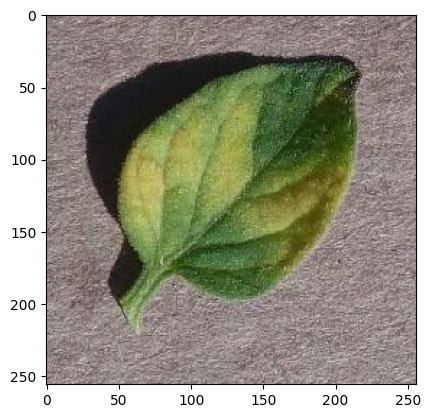

In [51]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


Write a function for inference

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 27ms/step


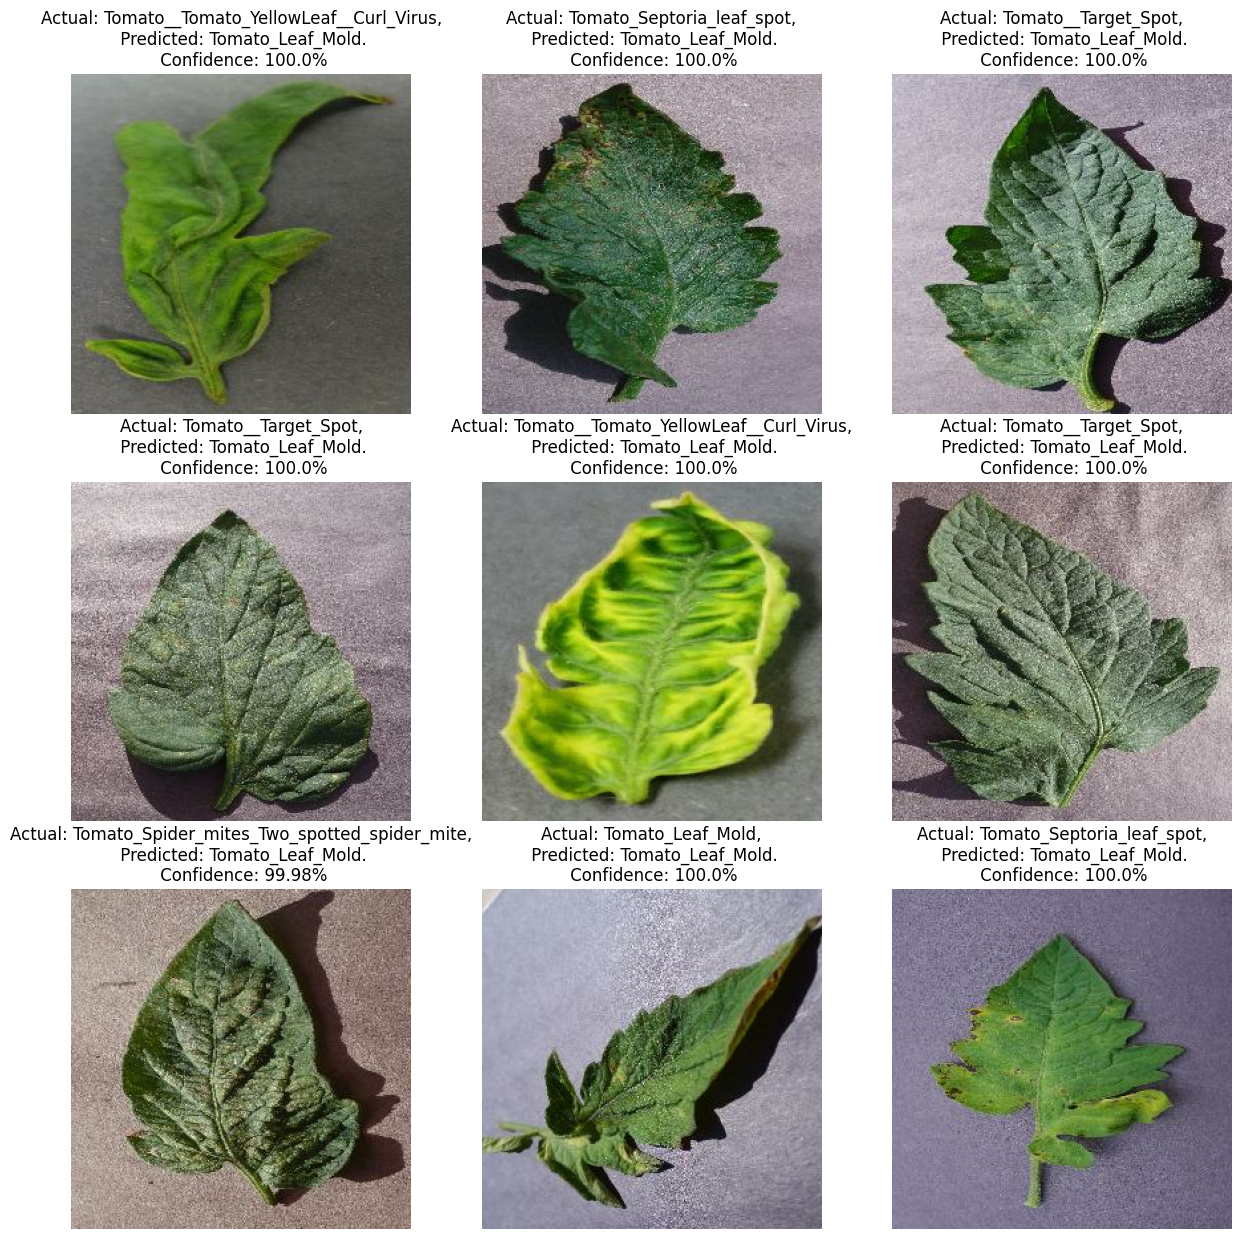

In [53]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


**Saving the Model**

In [54]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [55]:
import os
model_version=max([int(i) for i in os.listdir("model") + [0]])+1
model.save(f"../models/{model_version}")

In [56]:
model.save("Tomato-Disease-Detection(Transfer_Learning).h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
